In [ ]:
import random
import sys 
import os
import datetime

from google.colab import drive
from tqdm.notebook import tqdm
import subprocess

import numpy as np
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, top_k_accuracy_score

import keras
import tensorflow as tf

from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Activation, Flatten, Input, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing import image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
# Setting up classes

classes = ['bicycle', 'butterfly', 'castle', 'cat', 'eye', 'face', 'flower', 'hand', 'key', 'mermaid', 'pineapple', 'rabbit', 'snail', 'spider', 'truck']

label_encoder = preprocessing.LabelEncoder()
classes_indices = label_encoder.fit_transform(classes)

In [ ]:
# Downloading the data

for classe in tqdm(classes):
    if not os.path.exists(f'quickdraw_data/{classe}.npy'):
        !gsutil -m cp "gs://quickdraw_dataset/full/numpy_bitmap/{classe}.npy" "quickdraw_data/{classe}.npy"

  0%|          | 0/15 [00:00<?, ?it/s]

Copying gs://quickdraw_dataset/full/numpy_bitmap/bicycle.npy...
| [1/1 files][ 94.6 MiB/ 94.6 MiB] 100% Done                                    
Operation completed over 1 objects/94.6 MiB.                                     
Copying gs://quickdraw_dataset/full/numpy_bitmap/butterfly.npy...
/ [1/1 files][ 88.2 MiB/ 88.2 MiB] 100% Done                                    
Operation completed over 1 objects/88.2 MiB.                                     
Copying gs://quickdraw_dataset/full/numpy_bitmap/castle.npy...
| [1/1 files][ 91.6 MiB/ 91.6 MiB] 100% Done                                    
Operation completed over 1 objects/91.6 MiB.                                     
Copying gs://quickdraw_dataset/full/numpy_bitmap/cat.npy...
/
Operation completed over 1 objects/92.1 MiB.                                     
Copying gs://quickdraw_dataset/full/numpy_bitmap/eye.npy...
|
Operation completed over 1 objects/94.1 MiB.                                     
Copying gs://quickdraw_dataset

In [ ]:
# Constructing X

nb_image = 50000
images = []
labels = []

for classe in tqdm(classes):
    data = np.load(f'quickdraw_data/{classe}.npy')
    random_picks = np.random.choice(data.shape[0], min(nb_image, data.shape[0]), replace=False)
    images.append(data[random_picks])
    classes_indice = label_encoder.transform([classe])
    labels.append(np.full(random_picks.shape[0], classes_indice[0], dtype=int))

X = np.vstack(images).astype('float32').reshape(-1, 28, 28, 1)
X /= 255
y = np.hstack(labels)

print(X.shape)
print(y.shape)

  0%|          | 0/15 [00:00<?, ?it/s]

(750000, 28, 28, 1)
(750000,)


In [ ]:
# Splitting and shuffling X

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33, 
                                                    random_state=42,
                                                    shuffle=True,
                                                    stratify=y)

print('X_train.shape :', X_train.shape)
print('y_train.shape : ', y_train.shape)

print('X_test.shape :', X_test.shape)
print('y_test.shape :', y_test.shape)

X_train.shape : (502500, 28, 28, 1)
y_train.shape :  (502500,)
X_test.shape : (247500, 28, 28, 1)
y_test.shape : (247500,)


In [ ]:
# CNN Model
model = Sequential()
model.add(Input(shape=(28, 28, 1)))

model.add(Conv2D(32, (5, 5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(32, (5, 5), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.25))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(rate=0.5))

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(len(classes), activation='softmax'))

model.compile(optimizer='adam',
              metrics=['accuracy'],
              loss = 'sparse_categorical_crossentropy')

model.summary()

In [ ]:
# Callbacks and training

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.1,
                              patience=3,
                              min_lr=0.0001,
                              verbose=0)

logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

history = model.fit(X_train, y_train, epochs=50, validation_split=0.10, callbacks=[reduce_lr])

Epoch 1/50
14133/14133 [==============================] - 113s 7ms/step - loss: 0.5424 - accuracy: 0.8445 - val_loss: 0.2261 - val_accuracy: 0.9352 - lr: 0.0010
Epoch 2/50
14133/14133 [==============================] - 102s 7ms/step - loss: 0.2828 - accuracy: 0.9215 - val_loss: 0.1780 - val_accuracy: 0.9492 - lr: 0.0010
Epoch 3/50
14133/14133 [==============================] - 104s 7ms/step - loss: 0.2416 - accuracy: 0.9328 - val_loss: 0.1646 - val_accuracy: 0.9523 - lr: 0.0010
Epoch 4/50
14133/14133 [==============================] - 103s 7ms/step - loss: 0.2210 - accuracy: 0.9386 - val_loss: 0.1544 - val_accuracy: 0.9558 - lr: 0.0010
Epoch 5/50
14133/14133 [==============================] - 104s 7ms/step - loss: 0.2083 - accuracy: 0.9419 - val_loss: 0.1461 - val_accuracy: 0.9586 - lr: 0.0010
Epoch 6/50
14133/14133 [==============================] - 103s 7ms/step - loss: 0.1977 - accuracy: 0.9448 - val_loss: 0.1472 - val_accuracy: 0.9570 - lr: 0.0010
Epoch 7/50
14133/14133 [==========

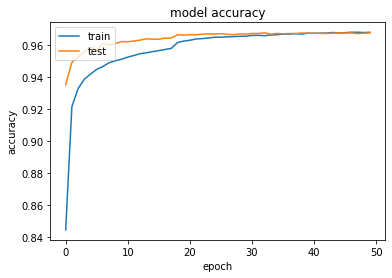

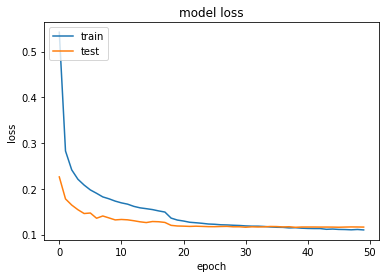

In [ ]:
# Plotting accuracy and loss

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Accuracy tests

y_score = model.predict(X_test)
y_pred = np.argmax(y_score, axis=-1)
print(classification_report(y_test, y_pred, target_names=classes))
print("\nTop 5 accuracy: ", top_k_accuracy_score(y_test, y_score, k=5))
print("Top 3 accuracy: ", top_k_accuracy_score(y_test, y_score, k=3))

              precision    recall  f1-score   support

     bicycle       0.99      0.99      0.99     16500
   butterfly       0.99      0.98      0.98     16500
      castle       0.99      0.98      0.98     16500
         cat       0.92      0.95      0.93     16500
         eye       0.97      0.97      0.97     16500
        face       0.97      0.98      0.97     16500
      flower       0.97      0.98      0.97     16500
        hand       0.97      0.96      0.97     16500
         key       0.94      0.96      0.95     16500
     mermaid       0.93      0.97      0.95     16500
   pineapple       0.98      0.98      0.98     16500
      rabbit       0.95      0.91      0.93     16500
       snail       0.98      0.97      0.98     16500
      spider       0.97      0.96      0.97     16500
       truck       0.98      0.98      0.98     16500

    accuracy                           0.97    247500
   macro avg       0.97      0.97      0.97    247500
weighted avg       0.97   

In [ ]:
# Saving model
drive.mount('/content/drive')
model.save("/content/drive/MyDrive/quickdraw_thumbnail_classifier.h5", save_format='h5')